In [1]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import numpy as np
#from mpl_toolkits import mplot3d
#%matplotlib widget

In [102]:
data = pd.read_excel('Data/full_data_2021-11-08.xlsx')

In [103]:
id = 0
temp = data.loc[0, 'Temperature']
poly = data.loc[0, 'Polymer']
for i in data.index:
    if data.loc[i, 'Temperature'] == temp and data.loc[i, 'Polymer'] == poly:
        data.loc[i, 'SAMPLE_ID'] = id
    else:
        id += 1
        data.loc[i, 'SAMPLE_ID'] = id
    
    temp = data.loc[i, 'Temperature']
    poly = data.loc[i, 'Polymer']

for c in ['Mw', 'Melt_Viscosity']:
    data[c] = np.log10(data[c])

fp_cols = []
for c in data.columns:
    if 'afp' in c or 'bfp' in c or 'mpf' in c or 'efp' in c:
        fp_cols.append(c)

In [104]:
z_shear_samples = []
sample_id = list(data.loc[data['Shear_Rate'] == 0].agg({'SAMPLE_ID': 'unique'})[0])
zero_shear_data = data[data['SAMPLE_ID'].isin(z_shear_samples)]
for i in range(len(sample_id)):
    if sum(data.loc[data['SAMPLE_ID'] == sample_id[i], 'Shear_Rate'].to_list()) == 0:
        z_shear_samples.append(i)

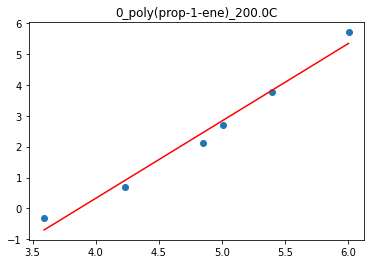

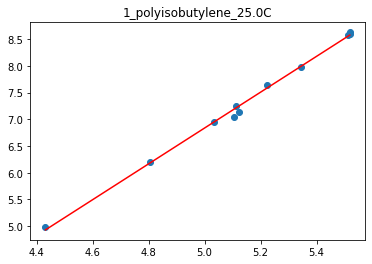

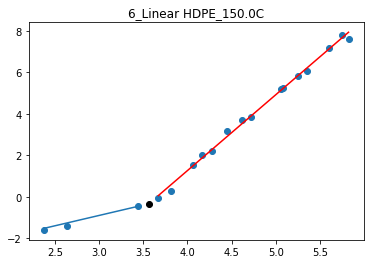

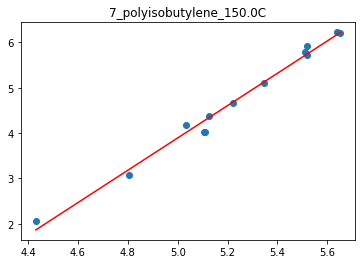

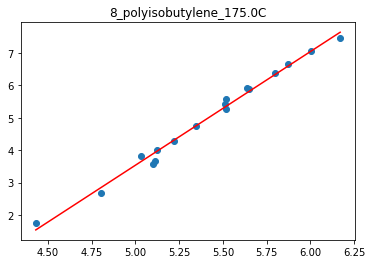

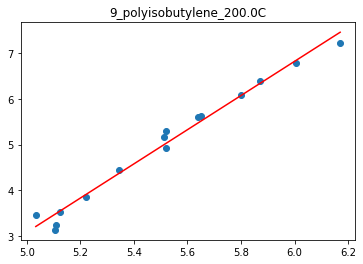

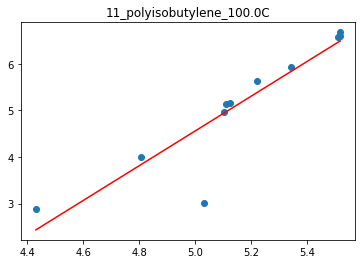

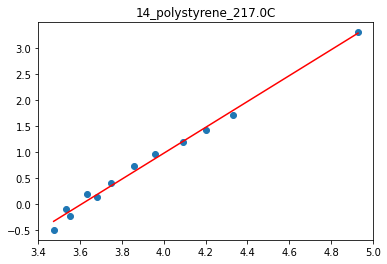

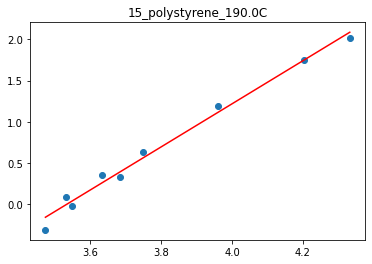

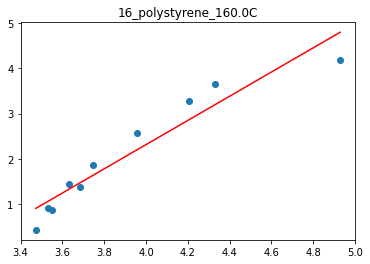

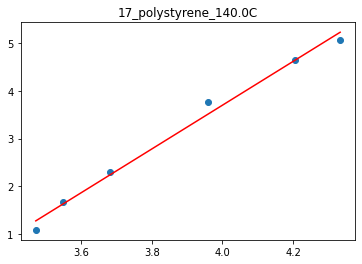

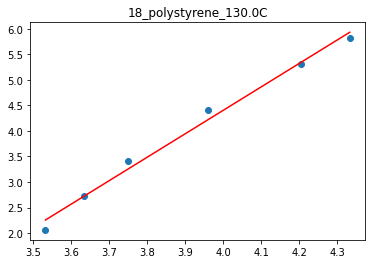

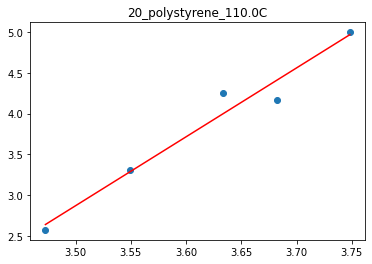

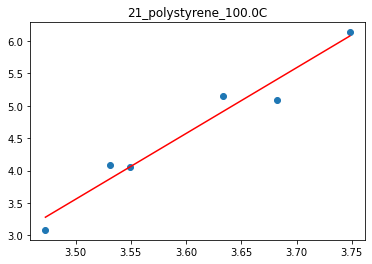

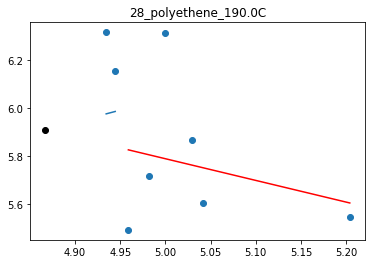

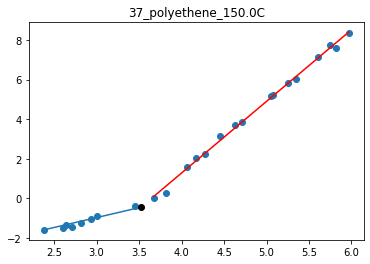

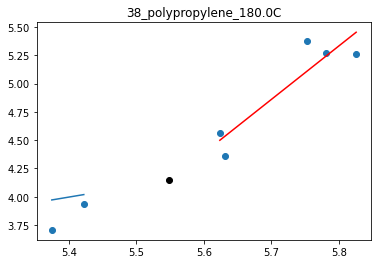

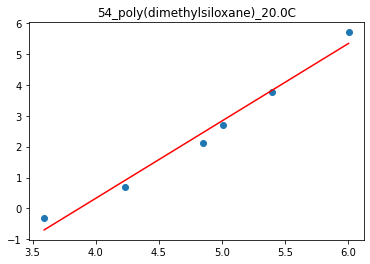

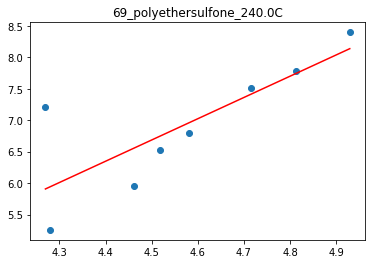

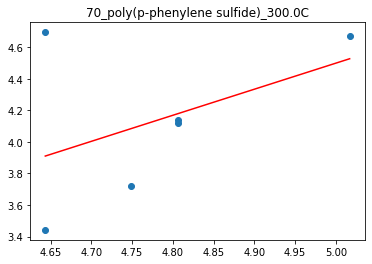

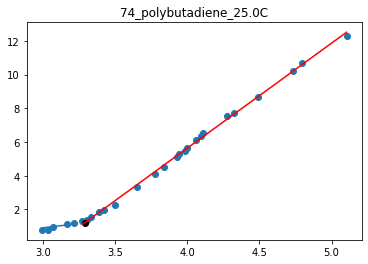

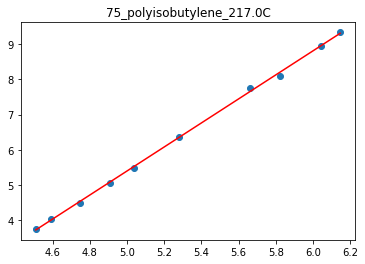

In [169]:
PL_data = pd.DataFrame(columns = ['SAMPLE_ID', 'Polymer', 'SMILES', 'Temperature', 'Mcr', 'Log_K1', 'Log_K2', 'Alpha'])
x_overall = []
y_overall = []
T_overall = []
data = data[data['Shear_Rate'] == 0]

for i in z_shear_samples:
    x = data.loc[data['SAMPLE_ID'] == i, 'Mw'].to_list()
    
    if len(x) == 0: continue
    if type(x[0]) != float or pd.isnull(x[0]): continue
    x_overall = x_overall + x
    y = data.loc[data['SAMPLE_ID'] == i, 'Melt_Viscosity'].to_list()
    y_overall = y_overall + y
    T =  data.loc[data['SAMPLE_ID'] == i, 'Temperature'].to_list()
    T_overall = T_overall + T
    
    
    if len(x) < 5: continue
    
    
    ind = np.argsort(x)
    x = [x[i] for i in ind]
    y = [y[i] for i in ind]
    #print(i)
    
    poly = data.loc[data['SAMPLE_ID'] == i, 'Polymer'].to_list()[0]
    temp = T[0]
    p = 2
    Rel_E = 0
    log_k_old = 0
    while Rel_E < 0.1:
        #print('p = ' + str(p))
        log_k1 = np.mean(np.array(y[0:p]) - np.array(x[0:p]))
        #print('logk1 = ' + str(log_k1))

        y_pred = (x[0:p]) + log_k1

        RMSE = np.sqrt(np.sum(np.power(y[0:p] - y_pred,2))/len(y_pred))
        Rel_E = RMSE
        #print("Rel_E = " + str(Rel_E))
        p+=1
        log_k_old = log_k1

    p -= 2
    log_k1 = log_k_old
    if p == 1 or p == 0: 
        p = 0
        log_k1 = 0
    #print("p final = " + str(p))

    x2 = x[p:]
    y2 = y[p:]
    
    fit = np.polyfit(x2,y2,1)
    if p > 0: Mcr = np.power(10, (log_k1 - fit[1])/ (fit[0] - 1))
    #print(fit)
    
    y1_pred = np.array(x[0:p]) + log_k1
    y2_pred = np.array(x2)*fit[0] + fit[1]
    
    ax = plt.gca()
    ax.set_title(i)
    plt.scatter(x, y)
    plt.title(str(i) + "_" + poly + "_" + str(temp) + 'C')
    if p > 0: plt.scatter(np.log10(Mcr), np.log10(Mcr) + log_k1, c = 'k')
    if p > 0: plt.plot(x[0:p], y1_pred)
    plt.plot(x2, y2_pred, 'r')
    plt.show()
    PL_data.set_index('SAMPLE_ID')
    if np.sqrt(np.sum(np.power(y2 - y2_pred,2))/len(y2_pred)) < 0.5:
        PL_data = PL_data.append({'SAMPLE_ID' : i, 'Polymer': poly, 
                    'SMILES' : data.loc[data['SAMPLE_ID'] == i, 'SMILES'].to_list()[0], 
                    'Temperature' : temp, 
                    'Mcr': Mcr if p > 0 else np.NaN, 'Log_K1': log_k1, 'Log_K2' : fit[1], 
                    'Alpha': fit[0]}, ignore_index = True)
        #PL_data = PL_data.reset_index(drop = True)
        PL_data.loc[i, fp_cols + ['SAMPLE_ID']] = data.loc[data['SAMPLE_ID'] == i, fp_cols + ['SAMPLE_ID']].reset_index().loc[0]
    
# ax = plt.gca()
# ax.set_yscale('log')
# ax.set_xscale('log')
# ax.set_title('overall zero shear')
# plt.scatter(x_overall, y_overall)
# plt.show
    

In [151]:
PL_data.loc[PL_data['SAMPLE_ID'] == 0, fp_cols] = data.loc[data['SAMPLE_ID'] == 75, fp_cols].reset_index().loc[0, fp_cols]

In [171]:
PL_data = PL_data.groupby('SAMPLE_ID').max().reset_index()
PL_data = PL_data[[x == y for x, y in zip(PL_data['Alpha'] > 2, PL_data['Alpha'] < 5)]]

In [201]:
out = pd.DataFrame()
y_pred = []
M = []
for i in np.random.choice(PL_data.index, size= 5):
    log_Mw = np.random.rand(1)*10 + 1 if PL_data.loc[i, 'Log_K2'] != 0 else np.random.rand(1)*6.5 + 4.5
    if  PL_data.loc[i, 'Log_K2'] != 0:
        y_pred.append(log_Mw*PL_data.loc[i, 'Alpha'] +  PL_data.loc[i, 'Log_K2'])
    else:
        if np.log10(PL_data.loc[i, 'Mcr']) > log_Mw:
            y_pred.append(log_Mw*PL_data.loc[i, 'Alpha'] +  PL_data.loc[i, 'Log_K2'])
        else:
            y_pred.append(log_Mw + PL_data.loc[i, 'Log_K1'])
    out = out.append(PL_data.loc[i]).reset_index(drop = True)
    y_pred[-1] = y_pred[-1][0]
    M.append(log_Mw[0])
out['y_pred'] = y_pred
out['log_Mw'] = M

[16.647939788466125]
[16.647939788466125, 3.6430179354597136]
[16.647939788466125, 3.6430179354597136, 5.484438196187465]
[16.647939788466125, 3.6430179354597136, 5.484438196187465, 34.413928626479255]
[16.647939788466125, 3.6430179354597136, 5.484438196187465, 34.413928626479255, 5.835425952195612]


In [202]:
out

,SAMPLE_ID,Temperature,Mcr,Log_K1,Log_K2,Alpha,afp_C4_C4_C4,afp_C4_C4_F1,afp_F1_C4_F1,bfp_299,...,bfp_429,afp_C3_C3_N3,afp_C3_N3_C3,bfp_46,bfp_47,bfp_55,bfp_79,bfp_210,y_pred,log_Mw
0,16.0,160.0,NaN,0.0,-8.345240,2.664743,0.125000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,16.647940,9.379208
1,0.0,200.0,NaN,0.0,-9.667328,2.499047,0.444444,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.643018,5.326170
2,16.0,160.0,NaN,0.0,-8.345240,2.664743,0.125000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.484438,5.189873
3,17.0,140.0,NaN,0.0,-14.696159,4.598960,0.125000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,34.413929,10.678520
4,0.0,200.0,NaN,0.0,-9.667328,2.499047,0.444444,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.835426,6.203467


In [14]:
ax = plt.axes(projection='3d')
ax.set_title('overall zero shear')
ax.scatter3D(np.log10(x_overall), T_overall ,np.log10(y_overall))
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

In [176]:
PL_data.index

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 14, 15, 16, 19], dtype='int64')